In [221]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

N = scipy.stats.norm.cdf
n = scipy.stats.norm.pdf
sns.set_style("darkgrid")

np.random.seed(1)

Laboratory Assignments:

1.1: Implement delta-hedging for a simulated price trajectory and show that the cost of the hedge approaches zero as the frequency of rehedging increases to infinity.

1.2: Implement delta-gamma-hedging (a chosen variant) for a simulated price trajectory. Show that the cost is lower than that of the delta-hedge. Use the following condition for the second option strike: K2>K for call and K2<K for put.

1.3: Hedge funds use delta-hedging to minimize risk when trading options. Implement hedging strategies for a selected stock (APPLE, TESLA, KGHM, ASML) - use Black-Scholes formula to calculate option prices and greeks

General setup:
We sell an option (call) -> short position
We want to hedge the risk using Δ-hedging strategy
Remarks:
We need to have a price trajectory -> simulate it using GBM
We need to have the option premium at t=0 -> calculate it using the Black-Scholes price formula
We need Δ_t at each moment of rehedging -> calculate it using the formula for Δ in the Black-Scholes setup
The strategy outcome is random (dependent on a given price trajectory)
Repeat the procedure many times (with different realizations of GBM) and analyse the outcome distribution (pdf, mean, etc.)
Repeat the simulations for different rehedging frequency

### 1.1
 Implement delta-hedging for a simulated price trajectory and show that the cost of the hedge approaches zero as the frequency of rehedging increases to infinity.

In [440]:
class GBM():
    
    def __init__(self, sigma, mu, S0, T=2, dt=0.01):
        
        self.sigma = sigma
        self.mu = mu
        self.S0 = S0
        self.T = T
        self.dt = dt 
        
        norm = scipy.stats.norm.rvs(0, np.sqrt(dt), size = int(round(T/dt))) 
        Wt = np.cumsum(norm) #brownian motion
        
        self.trajectory = np.concatenate([np.array([self.S0]), self.S0*np.exp((mu-(self.sigma**2)/2)*np.arange(dt, T, step=dt) + self.sigma*Wt[:-1])])
        
    def plot(self):
        
        plt.plot(np.arange(self.T, step = self.dt), self.trajectory)
        plt.xlabel("t")
        plt.ylabel("S(t)")
        plt.show()
        
        
class Option():
    
    def __init__(self, K, brownian_motion, option_type):
        
        self.K = K
        self.brownian_motion = brownian_motion  
        self.r = self.brownian_motion.mu 
        self.option_type = option_type
        
    def d1(self, t):
        return (np.log(self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]/self.K) + (self.r + (self.brownian_motion.sigma)**2/2)*(self.brownian_motion.T - t)) / (self.brownian_motion.sigma*np.sqrt(self.brownian_motion.T - t))
     
    def d2(self, t):
        return self.d1(t) - self.brownian_motion.sigma * np.sqrt(self.brownian_motion.T - t)       
        
    def price_option(self, t=0):
        
        if self.option_type == "call":
            return self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))] * N(self.d1(t)) - self.K * np.exp(-self.r*self.brownian_motion.T)* N(self.d2(t))
        elif self.option_type == "put":
            return self.K*np.exp(-self.r*self.brownian_motion.T)*N(-self.d2(t)) - self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]*N(-self.d1(t))

    def delta(self, t=0):
        
        if self.option_type == "call":
            return N(self.d1(t))
        
        elif self.option_type == "put":
            return N(self.d1(t)) - 1
        
    def gamma(self, t=0):
        
        return n(self.d1(t))/(self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]*self.brownian_motion.sigma*np.sqrt(self.brownian_motion.T - t))
    
    def payoff(self):
        
        if self.option_type == "call":
            return np.max([self.brownian_motion.trajectory[-1] - self.K, 0])
        
        elif self.option_type == "put":
            return np.max([self.K - self.brownian_motion.trajectory[-1], 0])
        
        
        

        
        
        
        
        
        
        
        

### No hedging
----------------------

In [381]:
#no hedging

K = 110
r = 0.04
value_put_no_hedge = np.zeros(1000)
value_call_no_hedge = np.zeros(1000)
 
for mcs in np.arange(1000):
    gbm = GBM(0.2, 0.04, 100)  
    
    option_market_put = Option(K, gbm, "put")
    value_put_no_hedge[mcs] = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option())*np.exp(option_market_put.r*gbm.T) - option_market_put.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    value_call_no_hedge[mcs] = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option())*np.exp(option_market_call.r*gbm.T) - option_market_call.payoff())/option_market_call.price_option())

Text(0.5, 1.0, 'Call option no hedging')

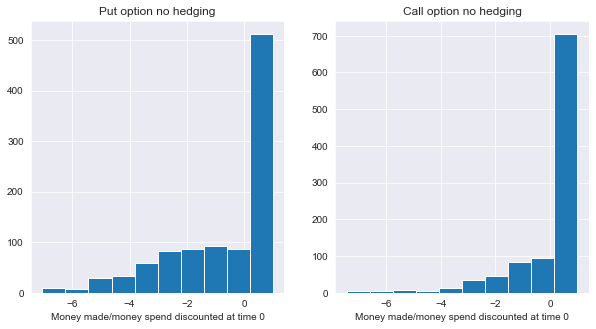

In [382]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_no_hedge)
ax1.set_xlabel("Money made/money spend discounted at time 0")
ax1.set_title("Put option no hedging")

ax2.hist(value_call_no_hedge)
ax2.set_xlabel("Money made/money spend discounted at time 0")
ax2.set_title("Call option no hedging")

### Hedging at $t=0$
---------------------------------

In [420]:
#one hedging

K = 110
r = 0.04
value_put_one_hedge = np.zeros(10000)
value_call_one_hedge = np.zeros(10000)
 
for mcs in np.arange(10000):
    gbm = GBM(0.2, 0.04, 100)  
    option_market_put = Option(K, gbm, "put")
    value_put_one_hedge[mcs] = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option() - option_market_put.delta()*gbm.trajectory[0])*np.exp(option_market_put.r*gbm.T) + option_market_put.delta()*gbm.trajectory[-1] - option_market_put.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    value_call_one_hedge[mcs] = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option() - option_market_call.delta()*gbm.trajectory[0])*np.exp(option_market_call.r*gbm.T) + option_market_call.delta()*gbm.trajectory[-1] - option_market_call.payoff())/option_market_call.price_option())

Text(0.5, 1.0, 'Call option one hedging')

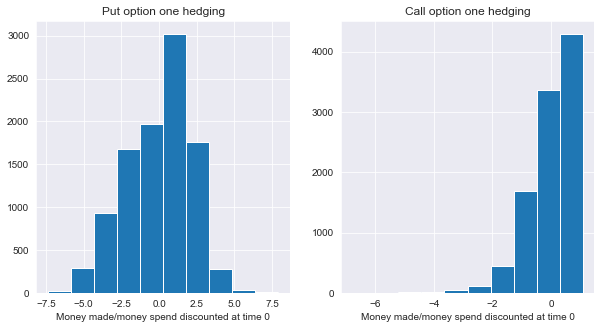

In [421]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_one_hedge)
ax1.set_xlabel("Money made/money spend discounted at time 0")
ax1.set_title("Put option one hedging")

ax2.hist(value_call_one_hedge)
ax2.set_xlabel("Money made/money spend discounted at time 0")
ax2.set_title("Call option one hedging")

### Hedging at $t=0$ and $t=1$
---------------------------------

In [441]:
#two hedgings

K = 110
r = 0.04
value_put_two_hedge = np.zeros(10000)
value_call_two_hedge = np.zeros(10000)
 
for mcs in np.arange(10000):
    gbm = GBM(0.2, 0.04, 100)  
    
    option_market_put = Option(K, gbm, "put") 
    assets_bought_compounded_put = option_market_put.delta(0)*gbm.trajectory[0]*np.exp(r*gbm.T) + (option_market_put.delta(1) - option_market_put.delta(0))*gbm.trajectory[int(np.round(1/gbm.dt))]*np.exp(r*(gbm.T-1))
    value_put_two_hedge[mcs] = np.exp(-r*gbm.T)*((option_market_put.price_option()*np.exp(option_market_put.r*gbm.T) - assets_bought_compounded_put + option_market_put.delta(1)*gbm.trajectory[-1] - option_market_put.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    assets_bought_compounded_call = option_market_call.delta(0)*gbm.trajectory[0]*np.exp(r*gbm.T) + (option_market_call.delta(1) - option_market_call.delta(0))*gbm.trajectory[int(np.round(1/gbm.dt))]*np.exp(r*(gbm.T-1))
    value_call_two_hedge[mcs] = np.exp(-r*gbm.T)*((option_market_call.price_option()*np.exp(option_market_call.r*gbm.T) - assets_bought_compounded_call + option_market_call.delta(1)*gbm.trajectory[-1] - option_market_call.payoff())/option_market_call.price_option())

Text(0.5, 1.0, 'Call option two hedgings')

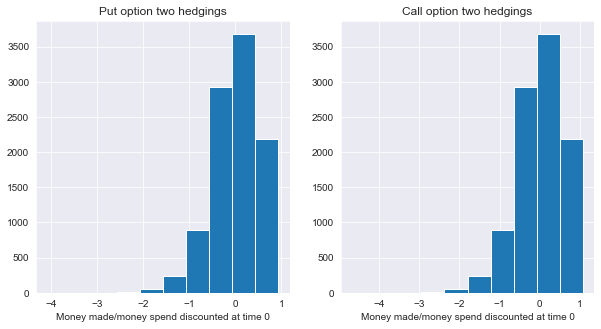

In [442]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_two_hedge)
ax1.set_xlabel("Money made/money spend discounted at time 0")
ax1.set_title("Put option two hedgings")

ax2.hist(value_call_two_hedge)
ax2.set_xlabel("Money made/money spend discounted at time 0")
ax2.set_title("Call option two hedgings")

### $n$ hedgings
___________________________________

In [443]:
#hedgings at each dt

K = 110
r = 0.04
value_put_n_hedge = np.zeros(1000)
value_call_n_hedge = np.zeros(1000)
df = 0.01
    
for mcs in np.arange(1000):
    gbm = GBM(0.2, 0.04, 100, dt=0.01)  
        
    option_market_put = Option(K, gbm, "put") 
    
    v0 = option_market_put.price_option(0) 
    delta_0 = option_market_put.delta(0)
    m0 = v0 - delta_0*gbm.trajectory[0]
    
    delta_prev = delta_0
    m_prev = m0
    for i in np.arange(1, len(gbm.trajectory)):
        delta_t = option_market_put.delta(i*dt)
        ut = delta_t - delta_prev
        mt = np.exp(r*dt)*m_prev - ut*gbm.trajectory[i]
        m_prev = mt
        delta_prev = delta_t
        
    value_put_n_hedge[mcs] = np.exp(-r*gbm.T)*(mt - option_market_put.payoff() + delta_prev*gbm.trajectory[-1])/v0
    
    
    option_market_call = Option(K, gbm, "call") 
    
    v0 = option_market_call.price_option(0) 
    delta_0 = option_market_call.delta(0)
    m0 = v0 - delta_0*gbm.trajectory[0]
    
    delta_prev = delta_0
    m_prev = m0
    for i in np.arange(1, len(gbm.trajectory)):
        delta_t = option_market_call.delta(i*dt)
        ut = delta_t - delta_prev
        mt = np.exp(r*dt)*m_prev - ut*gbm.trajectory[i]
        m_prev = mt
        delta_prev = delta_t
        
    value_call_n_hedge[mcs] = np.exp(-r*gbm.T)*(mt - option_market_call.payoff() + delta_prev*gbm.trajectory[-1])/v0
        
        

In [431]:
option_market_call.price_option(), delta_prev*gbm.trajectory[-1], option_market_call.payoff(), mt

(3.053888177019452, 113.39322508897716, 3.393225125608055, -51.021058774374055)

Text(0.5, 1.0, 'Call option hedgings continuously')

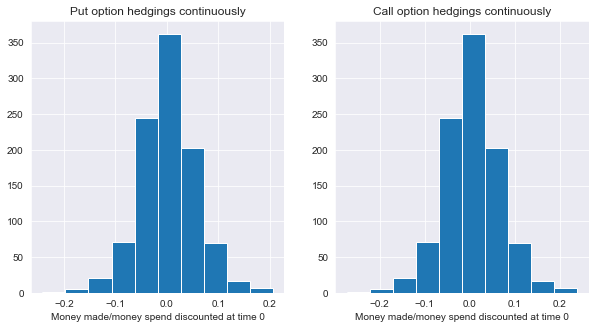

In [444]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_n_hedge)
ax1.set_xlabel("Money made/money spend discounted at time 0")
ax1.set_title("Put option hedgings continuously")

ax2.hist(value_call_n_hedge)
ax2.set_xlabel("Money made/money spend discounted at time 0")
ax2.set_title("Call option hedgings continuously")

In [248]:
N = scipy.stats.norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

def DELTA_CALL(t, S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    return N(d1)

def DELTA_PUT(t, S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    return -N(-d1)